In [ ]:
import os
import numpy as np

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Setting folder

In [2]:
%cd /content/drive/"My Drive"/IRE
!pwd

/content/drive/My Drive/IRE
/content/drive/My Drive/IRE


In [ ]:
# from getpass import getpass
# user = getpass('GitHub user')
# password = getpass('GitHub password')
# os.environ['GITHUB_AUTH'] = user + ':' + password
# !git clone https://github.com/DeepakSinghRawat/fastai-bert-finetuning.git

GitHub user··········
GitHub password··········
Cloning into 'fastai-bert-finetuning'...
remote: Enumerating objects: 54, done.
remote: Total 54 (delta 0), reused 0 (delta 0), pack-reused 54
Unpacking objects: 100% (54/54), done.


In [ ]:
# !git config --global user.name Mehul1604
# !git config --global user.email mathurmehul3@gmail.com

In [ ]:
# %mv Bert_Paraphrase_Identification.ipynb ./fastai-bert-finetuning/

In [3]:
%cd fastai-bert-finetuning/

/content/drive/My Drive/IRE/fastai-bert-finetuning


In [4]:
!ls

 bert_fastai.py
 bert_helper.py
 bert_para_learner.pth
 Bert_Paraphrase_Identification.ipynb
 download_glue_data.py
'Finetuning Bert on MRPC Corpus using FastAI.ipynb'
 glue_data
 images
 Paraphrase_Identification_Training_MRPC.ipynb
 Paraphrase_Identification_Training_PAWS.ipynb
 __pycache__
 README.md
 requirements.txt
 Testing_Best_Para_Model.ipynb
 utils.py


## Finetuning

In [5]:
! pip install -r requirements.txt

     |████████████████████████████████| 233 kB 5.4 MB/s 
     |████████████████████████████████| 123 kB 24.6 MB/s 
     |████████████████████████████████| 131 kB 46.8 MB/s 
     |████████████████████████████████| 8.1 MB 42.6 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 127 kB 45.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import utils, bert_fastai, bert_helper

In [7]:

# Seed random generators so all model runs are reproducible

utils.seed_everything()

### Getting data (MRPC)

In [8]:
# https://www.microsoft.com/en-us/download/details.aspx?id=52398
# Microsoft Research Paraphrase Corpus
TASK='MRPC'
DATA_ROOT = Path(".")
label_col = "Quality"
text_cols = ["#1 String", "#2 String"]

In [9]:
# Execute script to download MRPC data and create train.csv and test.csv

! python download_glue_data.py --data_dir='glue_data' --tasks=$TASK --test_labels=True

Processing MRPC...
Local MRPC data not specified, downloading data from https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
	Completed!


In [10]:
train_df = pd.read_csv(DATA_ROOT / "glue_data" / "MRPC" / "train.tsv", sep = '\t', quoting=csv.QUOTE_NONE)
train_df

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...
...,...,...,...,...,...
3663,1,1620264,1620507,""" At this point , Mr. Brando announced : ' Som...","Brando said that "" somebody ought to put a bul..."
3664,0,1848001,1848224,"Martin , 58 , will be freed today after servin...",Martin served two thirds of a five-year senten...
3665,1,747160,747144,""" We have concluded that the outlook for price...","In a statement , the ECB said the outlook for ..."
3666,1,2539933,2539850,The notification was first reported Friday by ...,MSNBC.com first reported the CIA request on Fr...


In [11]:
test_df = pd.read_csv(DATA_ROOT / "glue_data" / "MRPC" / "test.tsv", sep = '\t', quoting=csv.QUOTE_NONE)
test_df

,index,Quality,#1 ID,#2 ID,#1 String,#2 String
0,0,1,1089874,1089925,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...
1,1,1,3019446,3019327,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...
2,2,1,1945605,1945824,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,3,0,1430402,1430329,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,4,0,3354381,3354396,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...
...,...,...,...,...,...,...
1720,1720,0,2685984,2686122,"After Hughes refused to rehire Hernandez , he ...",Hernandez filed an Equal Employment Opportunit...
1721,1721,0,339215,339172,There are 103 Democrats in the Assembly and 47...,Democrats dominate the Assembly while Republic...
1722,1722,0,2996850,2996734,Bethany Hamilton remained in stable condition ...,"Bethany , who remained in stable condition aft..."
1723,1723,1,2095781,2095812,"Last week the power station ’ s US owners , AE...","The news comes after Drax 's American owner , ..."


In [12]:
print(f"Number of Training records={len(train_df)}")
print(f"Number of Test records={len(test_df)}")

Number of Training records=3668
Number of Test records=1725


In [13]:
def sample_sentences(quality, n=5):
    ctr = 0
    for row in train_df.query(f'Quality=={quality}').itertuples():
        print(f"1. {row[4]}\n2. {row[5]}")
        print("="*100)
        ctr += 1
        if n==ctr:
            break

In [14]:
# labelled as not same sentences
sample_sentences(0)

1. Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .
2. Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .
1. Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .
2. Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .
1. The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .
2. The tech-laced Nasdaq Composite .IXIC rallied 30.46 points , or 2.04 percent , to 1,520.15 .
1. That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .
2. Earnings were affected by a non-recurring $ 8 million tax benefit in the year-ago period .
1. Shares of Genentech , a much larger company with several products on the market , rose more than 2 percent .
2. Shares of Xoma fell 16 percent in early trade , while shares of Genentech , a much larger company with se

In [15]:
# labelled as similar
sample_sentences(1)

1. Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
2. Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
1. They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .
2. On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .
1. The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .
2. PG & E Corp. shares jumped $ 1.63 or 8 percent to $ 21.03 on the New York Stock Exchange on Friday .
1. Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier .
2. With the scandal hanging over Stewart 's company , revenue the first quarter of the year dropped 15 percent from the same period a year earlier .
1. The DVD-CCA then appealed to the state Supreme Court .
2. The DVD CCA appealed that 

### Training setup

In [18]:
# Configuration for fast ai learner
config = utils.Config(
    bert_model_name="bert-base-uncased",
    num_labels=2, # 0 or 1
    max_lr=2e-5,
    epochs=4,
    batch_size=32,
    max_seq_len=128
)

In [19]:
# Tokenizer for fast ai
fastai_tokenizer = bert_fastai.FastAITokenizer(model_name=config.bert_model_name, max_seq_len=config.max_seq_len)

In [20]:
# Creating a databunch object
databunch = TextDataBunch.from_df(".", train_df=train_df, valid_df=test_df,
                  tokenizer=fastai_tokenizer.bert_tokenizer(),
                  vocab=fastai_tokenizer.fastai_bert_vocab(),
                  include_bos=False,
                  include_eos=False,
                  text_cols=text_cols,
                  label_cols=label_col,
                  bs=config.batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

/usr/local/lib/python3.7/dist-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [21]:
# Show wordpiece tokenized data

for i in range(5): 
    print(f"Original==> {train_df.loc[i][text_cols[0]]},{train_df.loc[i][text_cols[1]]}\n\nTokenized==>. {databunch.x[i]}")
    print("="*100)

Original==> Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .,Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .

Tokenized==>. [CLS] am ##ro ##zi accused his brother , whom he called " the witness " , of deliberately di ##stor ##ting his evidence . referring to him as only " the witness " , am ##ro ##zi accused his brother of deliberately di ##stor ##ting his evidence . [SEP]
Original==> Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .,Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .

Tokenized==>. [CLS] yu ##ca ##ip ##a owned dominic ##k ' s before selling the chain to safe ##way in 1998 for $ 2 . 5 billion . yu ##ca ##ip ##a bought dominic ##k ' s in 1995 for $ 69 ##3 million and sold it to safe ##way for $ 1 . 8 billion in 1998 . [SEP]
Original==> They had published an adver

### Model

In [22]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification


bert_model = BertForSequenceClassification.from_pretrained(
    config.bert_model_name, num_labels=config.num_labels)

# initializing Learner object
learner = bert_fastai.BertLearner(databunch,
                                  bert_model,
                                  metrics=[accuracy])



learner.callbacks.append(ShowGraph(learner))

100%|██████████| 407873900/407873900 [00:12<00:00, 33983886.84B/s]


**Scores before training**<br>
*Accuracy = 33.8% , F1 score = 1.3%*

In [23]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.33855071663856506, f1_score=0.013828867761452032


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.615572,0.585727,0.704348,01:37
0,0.615572,0.585727,0.704348,01:37
1,0.498354,0.455152,0.805797,01:31
1,0.498354,0.455152,0.805797,01:31
2,0.346862,0.402653,0.822029,01:32
2,0.346862,0.402653,0.822029,01:32
3,0.268923,0.414614,0.828406,01:37
3,0.268923,0.414614,0.828406,01:37


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


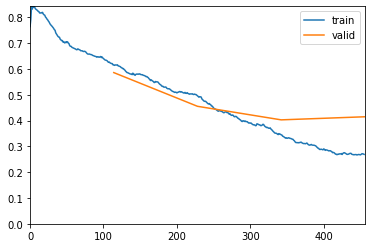

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [24]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

**Scores after training**<br>
*Accuracy = 82.84% , F1 Score = 87.2%*

In [25]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.8284057974815369, f1_score=0.8724137931034482
